In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras

np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 64   #How many images do we want to include in each batch
steps_per_epoch = 2500  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 30      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 128, 128, 4

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [3]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential


In [4]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

In [64]:
import numpy as np
x=np.load('/content/drive/MyDrive/Brain_tumor_Segmentation/GANS/asad data/5000 masks_array/numpy_array.npy')
x.shape

(5134, 128, 128)

In [65]:
import tensorflow as tf
x_cat=tf.keras.utils.to_categorical(x, num_classes=None, dtype='float32')
x_cat.shape

(5134, 128, 128, 4)

In [66]:
x_train=x_cat
x_train.shape

(5134, 128, 128, 4)

In [45]:
discriminator=keras.models.load_model('/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/discrimator')



In [46]:
generator=keras.models.load_model('/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 100/generator')

In [57]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 262144)            26476544  
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 262144)            0         
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 128)      524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 128, 128, 128)    262272    
 ranspose)                                            

In [58]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      2368      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)      

In [59]:
from keras.layers import Input
from keras.models import Model

discriminator = discriminator
generator = generator

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [61]:
import matplotlib.pyplot as plt
def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    generated_images=np.argmax(generated_images,axis=3)
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)))    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

In [60]:
path_generator='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 60/generator'
path_gan='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 60/full model'
path_discrim='/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/saved models /epoch 60/discrimator'

Epoch: 1 	 Discriminator Loss: 5.508532524108887 		 Generator Loss: 5.2210431022103876e-05


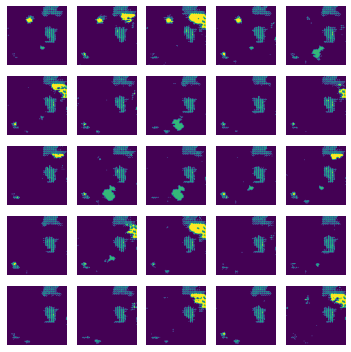

Epoch: 2 	 Discriminator Loss: 6.5895304679870605 		 Generator Loss: 6.674198630207684e-06


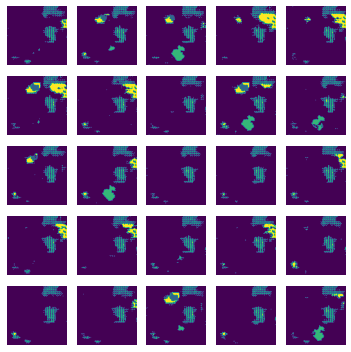

KeyboardInterrupt: ignored

In [67]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]###check this line  and its value in the first dimensions
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

##saving model    
generator.save(path_generator)
gan.save(path_gan)
discriminator.save(path_discrim)

In [68]:
generated_images = generator.predict(noise)   #Create the images from the GAN.

In [69]:
a=generated_images[3,:,:,:]

In [70]:
np.unique(a)

array([-1.       , -0.9999995, -0.9999986, ...,  0.9999998,  0.9999999,
        1.       ], dtype=float32)